In [40]:
import tensorflow
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import cv2
import pickle
from matplotlib import pyplot as plt
import cv2

In [2]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    tensorflow.keras.layers.GlobalAveragePooling2D(),
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


In [3]:
def extract_features(image_path, model):
    img = image.load_img(image_path, target_size=(224,224))
    img_arr = image.img_to_array(img)
    expanded_img_arr = np.expand_dims(img_arr, axis=0)
    preprocess_img = preprocess_input(expanded_img_arr)
    result = model.predict(preprocess_img, verbose=0).flatten()
    normalized_result = result / np.linalg.norm(result)
    return normalized_result

In [4]:
# filenames = []

# path = "/home/mastersindia/Projects/fashion_rec/images"
# for fn in os.listdir(path):
#     filenames.append(os.path.join(path,fn))

# Dump to pickle
# pickle.dump(filenames, open("filenames.pkl", "wb"))

In [5]:
# feature_list = []
# for image_path in tqdm(filenames):
#     feature_list.append(extract_features(image_path, model))

# Dump to pickle
# pickle.dump(feature_list, open('feature_list.pkl', 'wb'))

In [6]:
# Unpickle 
filenames = pickle.load(open("filenames.pkl", "rb"))
feature_list = pickle.load(open("feature_list.pkl", "rb"))

In [60]:
def inference(image_path,model, algorithm='brute', metric='euclidean'):
    normalized_result = extract_features(image_path, model)
    neighbours = NearestNeighbors(n_neighbors=5, algorithm=algorithm, metric=metric)
    neighbours.fit(feature_list)
    distances, indices = neighbours.kneighbors([normalized_result])
    return indices[0], distances[0]    

In [43]:
def plot_results(path, indices, distances):
    # Load the main input image
    main_img = cv2.imread(path)
    main_img_rgb = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)

    # Create a subplot grid
    num_rows = 1           # Number of rows in the grid
    num_cols = len(indices) + 1  # Number of columns in the grid (add 1 for the main image)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, 4))

    # Display the main input image
    axes[0].imshow(main_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Main Image", fontsize=10, pad=5)

    for i in range(len(indices)):
        img = cv2.imread(filenames[indices[i]])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        axes[i+1].imshow(img_rgb)
        axes[i+1].axis('off')
        # Add title to the subplot
        title = f"Distance: {distances[i]:.4f}"  # You can customize the title here
        axes[i+1].set_title(title, fontsize=10, pad=5)  # Customize fontsize and padding as needed

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

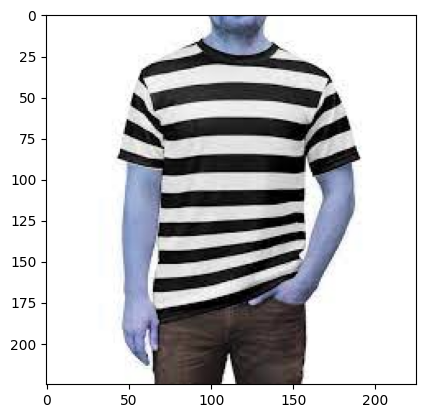

In [44]:
plt.imshow(cv2.imread(path))

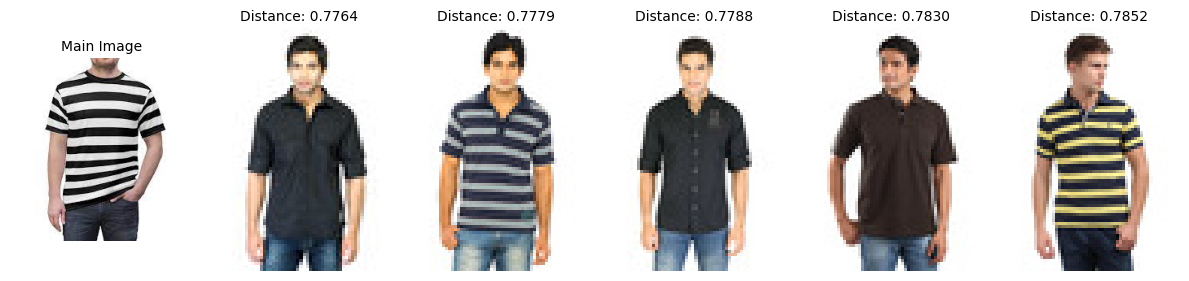

In [45]:
dir = 'samples for test'
# path = 'tshirt.png'
# path = 'bottle.jpg'
# path = 't2.jpg'
path = 'bwt.jpeg'

path = dir + '/' + path
indices, distances = inference(path, model)
plot_results(path, indices, distances)

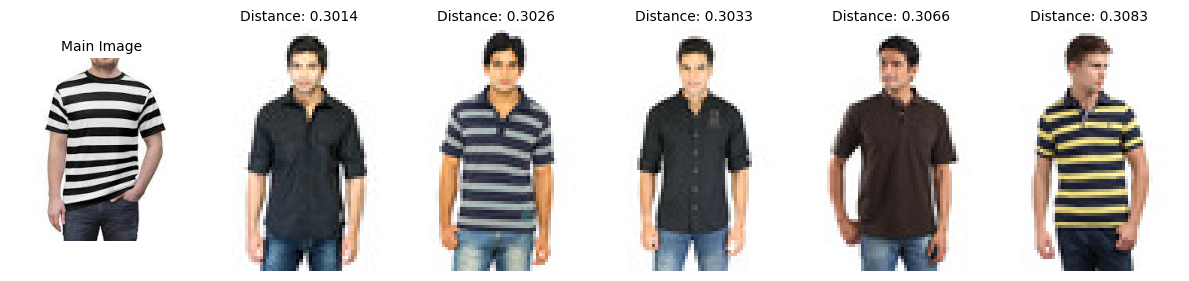

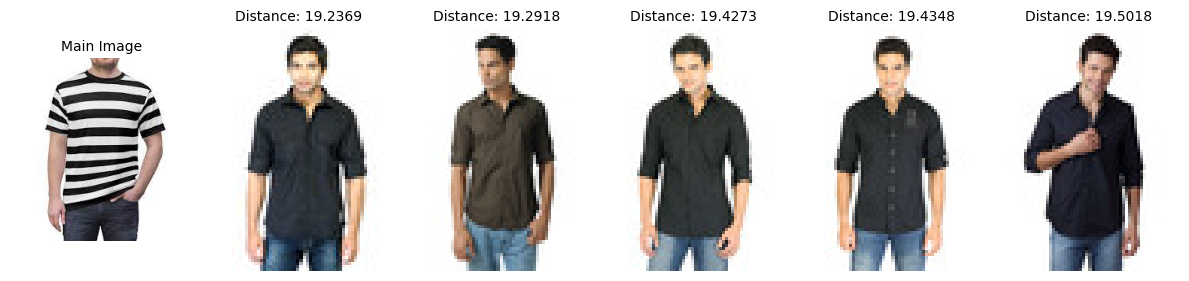

In [47]:
indices, distances = inference(path, model, distance='manhattan')
plot_results(path, indices, distances)

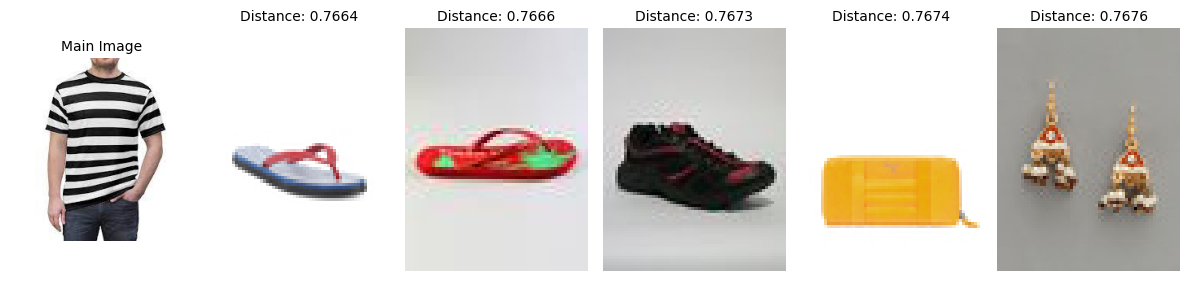

In [52]:
# Get SSIM distance
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim

indices, distances = inference(path, model, distance=ssim)
plot_results(path, indices, distances)

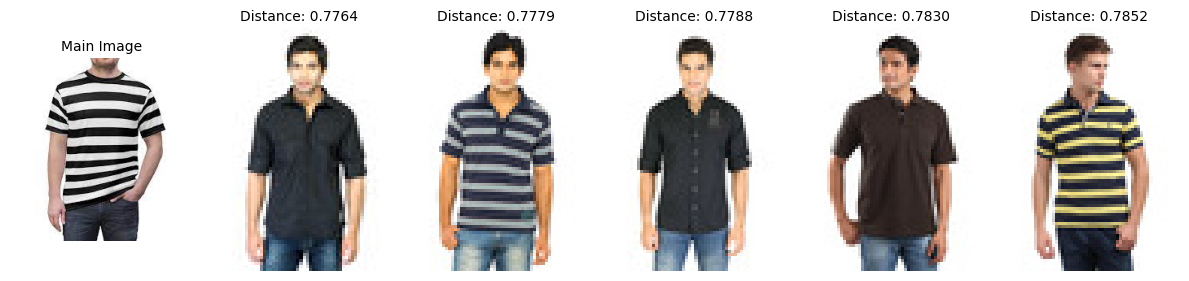

In [64]:
indices, distances = inference(path, model, algorithm='auto')
plot_results(path, indices, distances)